# Пятый стартер

Ну что, уже выжали достаточно много. Давай дожмем еще тысячу (спустимся ниже 9k). Хотя стоит сразу сказать, что это не так легко.💪 Работаем!

*Начало, как и в предыдущих стартерах, будет похожим, поэтому просто быстро "прокликаем"...*

## Импортируем библиотеки

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from tqdm import tqdm
import helper as h

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import re
import eli5

## Загружаем и объединяем

In [4]:
from platform import python_version
print(python_version())

3.7.2


Примечание: так как расчеты и эксперименты делал в ноутбуке с версией 3.7, а учебный ноутбук был сделан в версии 3.8 (из-за чего не поддерживались некоторые модули и методы) пришлось выгрузить датафрейм с развернутыми признаками из "offer_params" в CSV и затем считать его в ноутбук версии 3.7. Следовательно, код из версии 3.8. закомментировал

In [9]:
# df_train = pd.read_hdf("../input/df.train.h5")
# df_train["price_value"] = df_train['price_value'].map(h.parse_price)

# df_test = pd.read_hdf("../input/df.test.h5")

# print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [1]:
# df = h.get_df(df_train, df_test)

Примечание: CSV-файл большой, поэтому на гитхаб не загружен

In [5]:
df = pd.read_csv('../input/testtrain.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1,3,45,52,53,54,55,56,57,58,59,61,63,64,65,66,67,68,69,72,73,74,75,76,77,78,79,80,81,82,83,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['Безаварийный_cat',
 'Количество мест_cat',
 'Страна происхождения_cat',
 'Объем_cat',
 'Тип топлива_cat',
 'Коробка передач_cat',
 'Кредит_cat',
 'Первый владелец_cat',
 'Предложение от_cat',
 'Количество дверей_cat',
 'Пробег_cat',
 'Мощность_cat',
 'Металлик_cat',
 'Тип_cat',
 'Цвет_cat',
 'Модель автомобиля_cat',
 'Состояние_cat',
 'Категория_cat',
 'Обслуживание в сервисном центре_cat',
 'Привод_cat',
 'Лизинг_cat',
 'Год выпуска_cat',
 'Марка автомобиля_cat',
 'Счет-фактура по НДС_cat',
 'Первая регистрация_cat',
 'Зарегистрировано в Польше_cat',
 'Маржа НДС_cat',
 'Версия_cat',
 'VIN_cat',
 'Перламутр_cat',
 'Поврежденный_cat',
 'Код двигателя_cat',
 'Сажевый фильтр_cat',
 'Выбросы CO2_cat',
 'Ежемесячный платеж_cat',
 'Количество оставшихся платежей_cat',
 'Первоначальный платеж_cat',
 'Сумма погашения_cat',
 'Акрил (неметаллический)_cat',
 'Тюнинг_cat',
 'Правый руль (английский)_cat',
 'Допуск грузовика_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_ca

## Новые признаки 
С прошлых нотбуков.

In [7]:
df["year_production"] = df["Год выпуска"].astype(int)
df["year_production_ext"] = df.apply(lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1)

df["version_years"] = df["Версия"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

In [8]:
def check_log_model(df, feats, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

In [9]:
def check_log_model2(df, feats, model, cv=4, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    return result

## Тренируем модель

In [28]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
#h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

4it [00:11,  2.81s/it]


(9827.37120279568, 95.49558923097055)


Weight,Feature
0.4162,year_production_ext
0.1616,Привод_cat
0.0435,Коробка передач_cat
0.0366,Обслуживание в сервисном центре_cat
0.0299,Поврежденный_cat
0.0270,Тип_cat
0.0259,Счет-фактура по НДС_cat
0.0227,Безаварийный_cat
0.0199,Правый руль (английский)_cat
0.0146,Перламутр_cat


## В поисках новых признаков (учебный пример)

<AxesSubplot:>

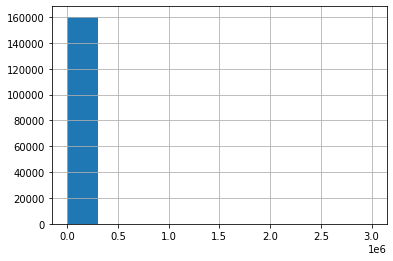

In [10]:
df["engine"] = df["Объем"].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype("int")
df["engine"].hist()

Нам нужно что немного поработать с выбросами. Миллион - это слишком большое значение. Что если мы для значений больше 99% будем ставить -1 (как будто-то мы их не знаем) 👀 .

In [11]:
def reset_outlires(df, feat, prc=99):
    cut_value = np.percentile(df[feat], 99)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

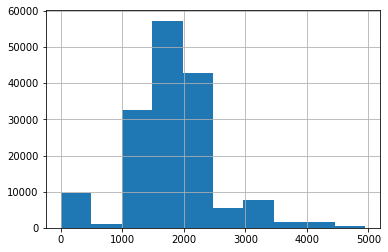

In [12]:
reset_outlires(df, "engine").hist();
df["engine_99"] = reset_outlires(df, "engine")

<AxesSubplot:>

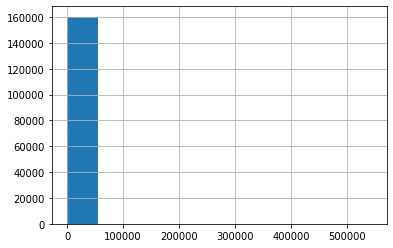

In [13]:
df["horse_power"] = df["Мощность"].map(lambda x: str(x).split("KM")[0].replace(" ", "")).astype("int")
df["horse_power"].hist()

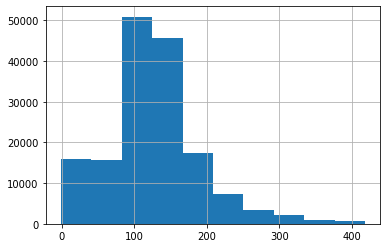

In [14]:
reset_outlires(df, "horse_power").hist();
df["horse_power_99"] = reset_outlires(df, "horse_power")

## Новые признаки, добавленные мной

### Мощность (прологарифмирована, чтобы снизить диапазон разброса значений)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

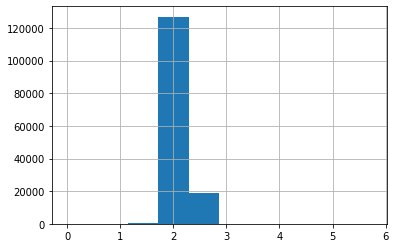

In [15]:
def parse_moc(val):
    if val !=-1:
        return np.log10(int(val.replace(" ", "").split('KM')[0]))
    else:
        return -1

df["Мощность_int"]=df["Мощность"].map(parse_moc)
df["Мощность_int"].hist()

### Пробег (два варианта - просто значение и прологарифмированное значение)

<AxesSubplot:>

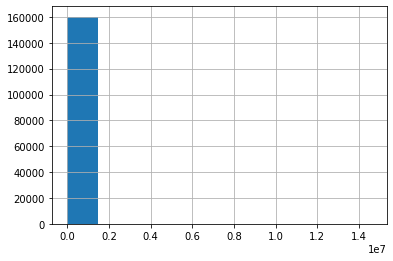

In [16]:
def parse_probeg(val):
    if val !=-1:
        
        
        #return np.log10(int(val.replace(" ", "").split('KM')[0]))
        return int(val.replace(" ", "").split('km')[0])
    else:
        return val

df["Пробег_int"]=df["Пробег"].map(parse_probeg)
df["Пробег_int"].hist()

<AxesSubplot:>

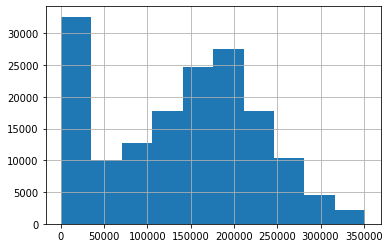

In [17]:
df["Пробег_int2"] = reset_outlires(df, "Пробег_int")
df["Пробег_int2"].hist()

<AxesSubplot:>

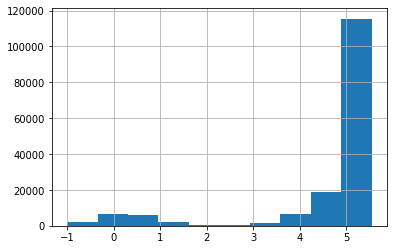

In [18]:
def parse_probeg_log(val):
    if val !=-1:
        if val !=0:
            return np.log10(val)
        else:
            return 0
    else:
        return -1

df["Пробег_int2_log"]=df["Пробег_int2"].map(parse_probeg_log)
df["Пробег_int2_log"].hist()

### engine_99 прологарифмировал, но не использовал в дальнейшем

In [38]:
df["engine_99_log"]=df["engine_99"].map(parse_probeg_log)

In [39]:
feats = ["year_production_ext", "engine_99_log", "Мощность_int", "version_year_from", "version_year_to", "Пробег_int2_log"] + cat_feats

In [40]:
cat_feats2=cat_feats.copy()

### Удалил следующие признаки:

- "Первая регистрация_cat", "VIN_cat" - они очень детальные (путают алгоритмы моделей) и при этом логически совсем не влияют на цену. (Первая регистрация обычно коррелирует с годом выпуска, а VIN-номер - это просто характеристика конкретного экземпляра автомобиля);
- "Объем_cat", "Пробег_cat", "Мощность_cat", "Год выпуска_cat" - по этим показателям мы добавили числовые показатели, поэтому удаляем, чтобы не путать алгоритм наличием признаков с высокой корреляцией

In [41]:
cat_feats2.remove("Первая регистрация_cat")
cat_feats2.remove("VIN_cat")
cat_feats2.remove("Объем_cat")
cat_feats2.remove("Пробег_cat")
cat_feats2.remove("Мощность_cat")
cat_feats2.remove("Год выпуска_cat")
feats = ["year_production_ext", "engine_99", "Мощность_int", "version_year_from", "version_year_to", "Пробег_int2_log"] + cat_feats2
feats10=feats.copy()

## Проведение экспериментов с разными списками признаков и настройками гиперпараметров модели

### Базовая модель, от которой отталкиваемся

In [42]:
check_log_model(df, feats10, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=0))

4it [00:20,  5.11s/it]


(7799.189054505528, 89.75700082022261)


Weight,Feature
0.3777,year_production_ext
0.0904,Мощность_int
0.0782,Привод_cat
0.0733,Коробка передач_cat
0.0424,Поврежденный_cat
0.0392,Безаварийный_cat
0.0354,Правый руль (английский)_cat
0.0233,Обслуживание в сервисном центре_cat
0.0196,Пробег_int2_log
0.0190,Тип_cat


### Далее изучаем, как изменяется модель при изменении двух гиперпараметров: max_depth (максимальная глубина дерева) и n_estimators (количество деревьев)

In [43]:
check_log_model(df, feats10, xgb.XGBRegressor(max_depth=7, n_estimators=100, learning_rate=0.3, random_state=0))

4it [00:28,  7.20s/it]


(7169.3933567733275, 108.82126369066967)


Weight,Feature
0.3776,year_production_ext
0.1017,Привод_cat
0.0955,Мощность_int
0.0420,Поврежденный_cat
0.0373,Правый руль (английский)_cat
0.0328,Коробка передач_cat
0.0194,Тип_cat
0.0193,Zarejestrowany jako zabytek_cat
0.0178,Безаварийный_cat
0.0161,Обслуживание в сервисном центре_cat


In [44]:
check_log_model(df, feats10, xgb.XGBRegressor(max_depth=7, n_estimators=150, learning_rate=0.3, random_state=0))

4it [00:44, 11.19s/it]


(6997.509603063656, 108.95480879927301)


Weight,Feature
0.3636,year_production_ext
0.1019,Привод_cat
0.0920,Мощность_int
0.0436,Правый руль (английский)_cat
0.0394,Поврежденный_cat
0.0320,Коробка передач_cat
0.0270,Zarejestrowany jako zabytek_cat
0.0191,Тип_cat
0.0174,Марка автомобиля_cat
0.0168,Безаварийный_cat


In [51]:
for itemdepth in [5,7,9,11]:
    for itemestim in [50,70,100,130,150,170,200]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [00:10,  2.71s/it]


5 -- 50 -- (8445.612897131436, 72.1454544501531)


4it [00:13,  3.46s/it]


5 -- 70 -- (8142.234554164508, 109.86598843945308)


4it [00:19,  4.99s/it]


5 -- 100 -- (7799.189054505528, 89.75700082022261)


4it [00:24,  6.24s/it]


5 -- 130 -- (7566.036334139273, 91.06698560375345)


4it [00:31,  7.91s/it]


5 -- 150 -- (7455.059781752638, 88.28181536369527)


4it [00:32,  8.23s/it]


5 -- 170 -- (7389.833007681424, 66.17316259897466)


4it [00:38,  9.62s/it]


5 -- 200 -- (7283.916692842598, 65.05322926035812)


4it [00:14,  3.63s/it]


7 -- 50 -- (7629.5541642201815, 72.25549551290828)


4it [00:19,  4.77s/it]


7 -- 70 -- (7364.339896732672, 107.47078234565947)


4it [00:31,  7.95s/it]


7 -- 100 -- (7169.3933567733275, 108.82126369066967)


4it [00:35,  8.99s/it]


7 -- 130 -- (7056.853808978906, 108.04643372596665)


4it [00:41, 10.42s/it]


7 -- 150 -- (6997.509603063656, 108.95480879927301)


4it [00:49, 12.37s/it]


7 -- 170 -- (6942.282563059231, 100.23639998813678)


4it [00:53, 13.32s/it]


7 -- 200 -- (6896.713229775109, 90.55427227342231)


4it [00:18,  4.67s/it]


9 -- 50 -- (7234.16621651366, 94.0194788096714)


4it [00:26,  6.55s/it]


9 -- 70 -- (7079.560588543102, 95.05685636351087)


4it [00:38,  9.74s/it]


9 -- 100 -- (6968.725196565073, 90.75303107485594)


4it [00:46, 11.70s/it]


9 -- 130 -- (6931.232753459424, 86.49057863965042)


4it [00:56, 14.08s/it]


9 -- 150 -- (6917.150163242474, 81.43927038406997)


4it [01:00, 15.15s/it]


9 -- 170 -- (6904.934127317678, 82.10287251336011)


4it [01:14, 18.58s/it]


9 -- 200 -- (6892.698526129403, 74.60925962422424)


4it [00:23,  5.92s/it]


11 -- 50 -- (7068.87811172653, 101.86757927540918)


4it [00:32,  8.23s/it]


11 -- 70 -- (6998.552523262311, 95.46599180464854)


4it [00:50, 12.54s/it]


11 -- 100 -- (6959.685107374374, 94.00967448840984)


4it [00:58, 14.73s/it]


11 -- 130 -- (6953.157088083993, 92.92874210920652)


4it [01:11, 18.00s/it]


11 -- 150 -- (6951.138473236523, 89.79047499580682)


4it [01:17, 19.42s/it]


11 -- 170 -- (6952.712523972173, 87.16454124338807)


0it [00:13, ?it/s]


KeyboardInterrupt: 

In [52]:
for itemdepth in [5,7,9]:
    for itemestim in [200,250,300]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [00:38,  9.60s/it]


5 -- 200 -- (7283.916692842598, 65.05322926035812)


4it [00:48, 12.15s/it]


5 -- 250 -- (7156.480521731209, 57.715560954816375)


4it [01:00, 15.18s/it]


5 -- 300 -- (7057.2307592293855, 30.97730050630389)


4it [00:55, 13.80s/it]


7 -- 200 -- (6896.713229775109, 90.55427227342231)


4it [01:09, 17.50s/it]


7 -- 250 -- (6852.474681442218, 93.95354588711841)


4it [01:21, 20.34s/it]


7 -- 300 -- (6816.694285406563, 86.61602268380541)


4it [01:14, 18.65s/it]


9 -- 200 -- (6892.698526129403, 74.60925962422424)


4it [01:33, 23.33s/it]


9 -- 250 -- (6877.509296373697, 74.3291793710409)


4it [01:49, 27.46s/it]

9 -- 300 -- (6879.140518092682, 75.11454786715528)


In [53]:
for itemdepth in [5]:
    for itemestim in [350,400,450,500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:08, 17.16s/it]


5 -- 350 -- (6991.07633781459, 28.544507664482627)


4it [01:21, 20.26s/it]


5 -- 400 -- (6935.360358260813, 24.987629166974514)


4it [01:29, 22.39s/it]


5 -- 450 -- (6898.580303371646, 27.90765302503082)


4it [01:35, 23.93s/it]

5 -- 500 -- (6866.521330831714, 31.080786628641736)


### Промежуточный вывод: пока лучшие параметры max_depth=5, n_estimators=500

При б'ольших параметрах max_depth наблюдается предел, к которому стремится ошибка при росте n_estimators и с какого-то момента это значение перестает улучшаться, причем чем выше max_depth, тем больше порог этой ошибки :
- max_depth=7 (6780 / 88) (ниже есть эти эксперименты)
- max_depth=9 (6879 / 75)
- max_depth=11 (6952 / 87)

Поэтому на данный момент выбрал базовые настройки max_depth=5, n_estimators=500.

### Теперь анализируем влияние на ошибку отдельных фич, которые раньше заменил или удалил.

Это надо, чтобы еще раз убедиться, что не допущены перекосы в наборе фич. Метод изучения простой - в каждом эксперименте заменяю / добавляю / удаляю только одну фичу. Степень изменения ошибки (увеличение либо уменьшение) показывает целесообразность данной фичи для модели. В качестве стартовой беру тот же Базовый набор фич, только в модели уже новые гиперпараметры.

In [54]:
feats_new = ["year_production_ext", "engine_99", "horse_power_99", "version_year_from", "version_year_to"] + cat_feats
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:43, 25.82s/it]

5 -- 500 -- (7432.515718515323, 77.5308507613843)


In [55]:
feats_new = ["year_production_ext", "engine_99", "horse_power_99", "version_year_from", "version_year_to",'Пробег_int2'] + cat_feats
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:43, 25.92s/it]

5 -- 500 -- (7119.961744587536, 82.52138519119727)


#### Хороший пример: на этом этапе при замене фичи 'Пробег_int2' на 'Пробег_int2_log' получили ухудшение параметра, поэтому пока отказались от такой замены

In [56]:
feats_new = ["year_production_ext", "engine_99", "horse_power_99", "version_year_from", "version_year_to",'Пробег_int2_log'] + cat_feats
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:46, 26.52s/it]

5 -- 500 -- (7147.83790286768, 83.45344167132316)


In [57]:
feats_new = ["year_production_ext", "engine_99", "Мощность_int", "version_year_from", "version_year_to",'Пробег_int2'] + cat_feats
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:49, 27.38s/it]

5 -- 500 -- (6972.401515722092, 67.17369146954991)


In [58]:
cat_feats3=feats_new.copy()

In [59]:
cat_feats3.remove("Первая регистрация_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:53, 28.25s/it]

5 -- 500 -- (6969.159754544432, 53.833849470697224)


In [60]:
cat_feats3.remove("VIN_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:44, 26.13s/it]

5 -- 500 -- (6921.921214406924, 44.31824693699155)


In [61]:
cat_feats3.remove("Объем_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:44, 26.15s/it]

5 -- 500 -- (6915.115181764567, 87.5267198404152)


In [62]:
cat_feats3.remove("Пробег_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:39, 24.79s/it]

5 -- 500 -- (6892.646645416924, 66.31459434002022)


In [63]:
cat_feats3.remove("Мощность_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:36, 24.19s/it]

5 -- 500 -- (6894.973761891679, 32.698675695123434)


In [64]:
cat_feats3.remove("Год выпуска_cat")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:35, 23.83s/it]

5 -- 500 -- (6889.417384092923, 26.16500498315065)


#### Здесь еще раз проверили 'Пробег_int2_log' - и в данном случае это улучшило результат.

In [67]:
cat_feats3.append('Пробег_int2_log')
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:43, 25.86s/it]

5 -- 500 -- (6889.417384092923, 26.16500498315065)


In [68]:
cat_feats3.remove("Пробег_int2")
feats_new = cat_feats3.copy()
for itemdepth in [5]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats_new, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [01:42, 25.67s/it]

5 -- 500 -- (6866.306254112485, 30.0902244590428)


Убедились, что ранее созданный набор фич является лучшим на данном этапе и применяем его для дальнейших экспериментов.

Примечание: аналогичным образом можно было еще экспериментировать с удалением других фич. Возможно нашлись бы еще, которые не влияют на цену и должны быть исключены из списка

### Далее экспериментирую с настройками гиперпараметров

In [70]:
for itemdepth in [7]:
    for itemestim in [500]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [02:18, 34.67s/it]

7 -- 500 -- (6782.777330067851, 93.21718120940238)


In [71]:
for itemdepth in [7]:
    for itemestim in [600]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [02:43, 40.95s/it]

7 -- 600 -- (6780.033155466299, 88.74627879841802)


In [72]:
for itemdepth in [5]:
    for itemestim in [700]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [02:23, 35.97s/it]

5 -- 700 -- (6778.50491719645, 27.91681279958952)


In [73]:
for itemdepth in [5]:
    for itemestim in [1000,1200,1400]:
        #print(itemdepth,'--',itemestim)
        res=check_log_model2(df, feats10, xgb.XGBRegressor(max_depth=itemdepth, n_estimators=itemestim, learning_rate=0.3, random_state=0))
        print(itemdepth,'--',itemestim,'--',res)

4it [03:10, 47.52s/it]


5 -- 1000 -- (6732.312739733736, 40.84478282066716)


4it [03:52, 58.15s/it]


5 -- 1200 -- (6719.135610506435, 36.06705414687975)


1it [01:12, 72.30s/it]


KeyboardInterrupt: 

## Фиксация результата

Предыдущую операцию прервал, так как уже понятно, что при max_depth=5, величина ошибки стремится где-то в район 6700. Увеличение n_estimators с 1000 до 1200 уже не дал существенного улучшения результата. 

Поэтому финальными настройками гиперпараметров модели выбрал max_depth=5, n_estimators=1200

In [74]:
feats = feats10.copy()

df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=5, n_estimators=1200, learning_rate=0.3, random_state=0)


model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_year_production_engine_etc.csv", index=False)

In [ ]:
# Kaggle: 6595. На кроссвалидации - (6719.135610506435, 36.06705414687975)
"""
Параметры модели:

feats = feats10.copy()

df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=5, n_estimators=1200, learning_rate=0.3, random_state=0)


model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_year_production_engine_etc.csv", index=False)

"""

"""
Список фич:

['year_production_ext',
 'engine_99',
 'Мощность_int',
 'version_year_from',
 'version_year_to',
 'Пробег_int2_log',
 'Безаварийный_cat',
 'Количество мест_cat',
 'Страна происхождения_cat',
 'Тип топлива_cat',
 'Коробка передач_cat',
 'Кредит_cat',
 'Первый владелец_cat',
 'Предложение от_cat',
 'Количество дверей_cat',
 'Металлик_cat',
 'Тип_cat',
 'Цвет_cat',
 'Модель автомобиля_cat',
 'Состояние_cat',
 'Категория_cat',
 'Обслуживание в сервисном центре_cat',
 'Привод_cat',
 'Лизинг_cat',
 'Марка автомобиля_cat',
 'Счет-фактура по НДС_cat',
 'Зарегистрировано в Польше_cat',
 'Маржа НДС_cat',
 'Версия_cat',
 'Перламутр_cat',
 'Поврежденный_cat',
 'Код двигателя_cat',
 'Сажевый фильтр_cat',
 'Выбросы CO2_cat',
 'Ежемесячный платеж_cat',
 'Количество оставшихся платежей_cat',
 'Первоначальный платеж_cat',
 'Сумма погашения_cat',
 'Акрил (неметаллический)_cat',
 'Тюнинг_cat',
 'Правый руль (английский)_cat',
 'Допуск грузовика_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_cat',
 'VAT discount_cat',
 'No accident_cat',
 'Mileage_cat',
 'Service record_cat',
 'Door count_cat',
 'Fuel type_cat',
 'Nr of seats_cat',
 'Gearbox_cat',
 'Transmission_cat',
 'Engine power_cat',
 'Model_cat',
 'Color_cat',
 'Country of origin_cat',
 'Body type_cat',
 'Year_cat',
 'Matowy_cat',
 'Acrylic_cat',
 'Financing option_cat',
 'Registered in Poland_cat',
 'Original owner_cat',
 'First registration_cat',
 'Pearl_cat',
 'Zarejestrowany jako zabytek_cat',
 'VAT free_cat',
 'Engine Code_cat',
 'Particle filter_cat',
 'Leasing concession_cat',
 'Damaged_cat',
 'CO2 emissions_cat',
 'Monthly payment value_cat']
 
"""
